# YoloNano论文复现（Test部分）

《YOLO Nano: a Highly Compact You Only Look Once Convolutional Neural Network for Object Detection》

# 1 网络模块定义
## 1.1 EP(Expansion-projection) module

In [1]:
import torch
import torch.nn as nn

class EP(nn.Module):
    def __init__(self,input_channel,output_channel,expansion=0.5,stride=2):
        super(EP,self).__init__()
        # conv2D(input_channel,output_channal,k_size)
        self.dw_channel = int(expansion*input_channel)
        self.input_channel = input_channel
        self.output_channel = output_channel
        
        self.conv1_1_1 = nn.Sequential(
            nn.Conv2d(input_channel,self.dw_channel,1),
            nn.BatchNorm2d(self.dw_channel),
            nn.LeakyReLU(),
        )
        self.dwconv = nn.Sequential(
            nn.Conv2d(self.dw_channel,self.dw_channel,3,groups=self.dw_channel,stride=stride,padding=1),
            nn.BatchNorm2d(self.dw_channel),
            nn.LeakyReLU(),
        )
        self.conv1_1_2 = nn.Sequential(
            nn.Conv2d(self.dw_channel,self.output_channel,1),
            nn.BatchNorm2d(self.output_channel),
        )
    def forward(self,Input):
        Output = self.conv1_1_1(Input)
        Output = self.dwconv(Output)
        Output = self.conv1_1_2(Output)
        if self.input_channel == self.output_channel:
            Output+=Input
        return Output
    
# test = torch.ones((1,24,208,208))
# ep = EP(24,70)
# print(ep(test).shape)

## 1.2 PEP module

In [2]:
class PEP(nn.Module):
    def __init__(self,input_channel,projection_channel,output_channel=None,expansion=0.5):
        super(PEP,self).__init__()
        # conv2D(input_channel,output_channal,k_size)
        self.input_channel = input_channel
        self.projection_channel = projection_channel
        self.output_channel = output_channel
        expand_channel = int(expansion*input_channel)
        self.conv1_1_1 = nn.Sequential(
            nn.Conv2d(input_channel,self.projection_channel,1),
            nn.BatchNorm2d(self.projection_channel),
            nn.LeakyReLU(),
        )
        self.conv1_1_2 = nn.Sequential(
            nn.Conv2d(self.projection_channel,expand_channel,1),
            nn.BatchNorm2d(expand_channel),
            nn.LeakyReLU(),
        )
        self.dwconv = nn.Sequential(
            nn.Conv2d(expand_channel,expand_channel,3,groups=expand_channel,stride=1,padding=1),
            nn.BatchNorm2d(expand_channel),
            nn.LeakyReLU(),
        )
        if self.output_channel == None:
            self.conv1_1_3 = nn.Sequential(
                nn.Conv2d(expand_channel,self.input_channel,1),
                nn.BatchNorm2d(self.input_channel),
            )
        else:
            self.conv1_1_3 = nn.Sequential(
                nn.Conv2d(expand_channel,self.output_channel,1),
                nn.BatchNorm2d(self.output_channel),
            )
    def forward(self,Input):
        Output = self.conv1_1_1(Input)
        Output = self.conv1_1_2(Output)
        Output = self.dwconv(Output)
        Output = self.conv1_1_3(Output)
        if self.output_channel == None:
            Output+=Input
#         print(Input.shape,Output.shape)
        return Output
    
# test = torch.ones((1,24,208,208))
# pep = PEP(24,70)
# print(pep(test).shape)

## 1.3 FCA module

In [3]:
class FCA(nn.Module):
    def __init__(self, channels, reduction_ratio):
        super(FCA, self).__init__()
        self.channels = channels
        self.reduction_ratio = reduction_ratio

        hidden_channels = channels // reduction_ratio
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, hidden_channels, bias=False),
            nn.ReLU6(inplace=True),
            nn.Linear(hidden_channels, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        out = self.avg_pool(x).view(b, c)
        out = self.fc(out).view(b, c, 1, 1)
        out = x * out.expand_as(x)
        return out

## 1.4 Yolo Layer

In [4]:
def bbox_wh_iou(wh1, wh2):
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area

In [5]:
def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

In [6]:
def build_targets(pred_boxes, pred_cls, target, anchors, ignore_thres):

    #print(pred_boxes.size(), pred_cls.size(), target.size(), anchors.size())

    ByteTensor = torch.cuda.ByteTensor if pred_boxes.is_cuda else torch.ByteTensor
    FloatTensor = torch.cuda.FloatTensor if pred_boxes.is_cuda else torch.FloatTensor

    nB = pred_boxes.size(0) # batch_num
    nA = pred_boxes.size(1) # anchor_num = 3
    nC = pred_cls.size(-1) # classes_num = 20
    nG = pred_boxes.size(2) # grid_num = 52

    # Output tensors
    obj_mask = ByteTensor(nB, nA, nG, nG).fill_(0)
    noobj_mask = ByteTensor(nB, nA, nG, nG).fill_(1)
    class_mask = FloatTensor(nB, nA, nG, nG).fill_(0)
    iou_scores = FloatTensor(nB, nA, nG, nG).fill_(0)
    tx = FloatTensor(nB, nA, nG, nG).fill_(0)
    ty = FloatTensor(nB, nA, nG, nG).fill_(0)
    tw = FloatTensor(nB, nA, nG, nG).fill_(0)
    th = FloatTensor(nB, nA, nG, nG).fill_(0)
    tcls = FloatTensor(nB, nA, nG, nG, nC).fill_(0)

#     Convert to position relative to box
    target_boxes = target[:, 2:6] * nG
#     print(target_boxes.shape,target.shape)
    gxy = target_boxes[:, :2]
    gwh = target_boxes[:, 2:]
    # Get anchors with best iou
#     print(gwh.shape)
    ious = torch.stack([bbox_wh_iou(anchor, gwh) for anchor in anchors])
    #print(ious.size(), gwh.size(), target.size())

    best_ious, best_n = ious.max(0)
#     print(best_ious.size(), best_n.size())

#     Separate target values
    b, target_labels = target[:, :2].long().t()
    gx, gy = gxy.t()
    gw, gh = gwh.t()
    gi, gj = gxy.long().t()
    # Set masks
#     print(b,best_n,gj,gi,obj_mask.shape)
    obj_mask[b, best_n, gj, gi] = 1
    noobj_mask[b, best_n, gj, gi] = 0

    # Set noobj mask to zero where iou exceeds ignore threshold
    for i, anchor_ious in enumerate(ious.t()):
        #print(noobj_mask.size())
        #print(b[i], anchor_ious>ignore_thres, gj[i], gi[i])
        noobj_mask[b[i], anchor_ious > ignore_thres, gj[i], gi[i]] = 0

    # Coordinates
    tx[b, best_n, gj, gi] = gx - gx.floor()
    ty[b, best_n, gj, gi] = gy - gy.floor()
    # Width and height
    tw[b, best_n, gj, gi] = torch.log(gw / anchors[best_n][:, 0] + 1e-16)
    th[b, best_n, gj, gi] = torch.log(gh / anchors[best_n][:, 1] + 1e-16)

    #print(tw[b,best_n, gj, gi])

    # One-hot encoding of label
    tcls[b, best_n, gj, gi, target_labels] = 1
    # Compute label correctness and iou at best anchor
    class_mask[b, best_n, gj, gi] = (pred_cls[b, best_n, gj, gi].argmax(-1) == target_labels).float()
    iou_scores[b, best_n, gj, gi] = bbox_iou(pred_boxes[b, best_n, gj, gi], target_boxes, x1y1x2y2=False)

    tconf = obj_mask.float()
    return iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf

In [7]:
class YOLOLayer(nn.Module):
    # detection layer
    def __init__(self, anchors, num_classes, img_dim=416):
        super(YOLOLayer, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.ignore_thres = .5
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()
        self.obj_scale = 1
        self.noobj_scale = 100
        self.metrics = {}
        self.img_dim = img_dim
        self.grid_size = 0

    def compute_grid_offsets(self, grid_size, cuda=True):
        self.grid_size = grid_size
        g = self.grid_size
        FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
        self.stride = self.img_dim / self.grid_size
        # Calculate offsets for each grid
        self.grid_x = torch.arange(g).repeat(g, 1).view([1, 1, g, g]).type(FloatTensor)
        self.grid_y = torch.arange(g).repeat(g, 1).t().view([1, 1, g, g]).type(FloatTensor)
        self.scaled_anchors = FloatTensor([(a_w / self.stride, a_h / self.stride) for a_w, a_h in self.anchors])
        self.anchor_w = self.scaled_anchors[:, 0:1].view((1, self.num_anchors, 1, 1))
        self.anchor_h = self.scaled_anchors[:, 1:2].view((1, self.num_anchors, 1, 1))

    def forward(self, x, targets=None, img_dim=416):
        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
        LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
        ByteTensor = torch.cuda.ByteTensor if x.is_cuda else torch.ByteTensor

        self.img_dim = img_dim

        num_samples = x.size(0)
        grid_size = x.size(2)

        prediction = (
            x.view(num_samples, self.num_anchors, self.num_classes+5, grid_size, grid_size)
            .permute(0,1,3,4,2)
            .contiguous()
        )
#         print(prediction.shape)
#         torch.Size([1, 3, 26, 26, 25])
        x = torch.sigmoid(prediction[..., 0]) # center x
        y = torch.sigmoid(prediction[..., 1]) # center y
        w = prediction[..., 2] # width
        h = prediction[..., 3] # Height
        pred_conf = torch.sigmoid(prediction[..., 4]) # Conf # bbox的置信度
        pred_cls = torch.sigmoid(prediction[..., 5:]) # Cls Pred

        if grid_size != self.grid_size:
            self.compute_grid_offsets(grid_size, cuda=x.is_cuda)

        # Add offset and scale with anchors
        pred_boxes = FloatTensor(prediction[..., :4].shape)
        pred_boxes[..., 0] = x.data + self.grid_x
        pred_boxes[..., 1] = y.data + self.grid_y
        pred_boxes[..., 2] = torch.exp(w.data) * self.anchor_w
        pred_boxes[..., 3] = torch.exp(h.data) * self.anchor_h
#         print(pred_boxes.size())
#         torch.Size([1, 3, 52, 52, 4])
#         print(pred_boxes.view(num_samples, -1, 4).size())
#         print(pred_conf.view(num_samples,-1,1).size())
#         print(pred_cls.view(num_samples,-1,self.num_classes).size())

        output = torch.cat(
            (
                pred_boxes.view(num_samples, -1, 4) * self.stride,# 真实的bbox的值
                pred_conf.view(num_samples, -1, 1), # bbox置信度
                pred_cls.view(num_samples, -1, self.num_classes), # 每一类的一个置信度
            ),
            -1,
        )

        if targets is None:
            return output, 0
        else:
            iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf = build_targets(
                pred_boxes=pred_boxes,
                pred_cls=pred_cls,
                target=targets,
                anchors=self.scaled_anchors,
                ignore_thres=self.ignore_thres,
            )

            # Loss : Mask outputs to ignore non-existing objects (except with conf. loss)
            loss_x = self.mse_loss(x[obj_mask], tx[obj_mask])
            loss_y = self.mse_loss(y[obj_mask], ty[obj_mask])
            loss_w = self.mse_loss(w[obj_mask], tw[obj_mask])
            loss_h = self.mse_loss(h[obj_mask], th[obj_mask])
            #print(pred_conf[obj_mask], tconf[obj_mask])
            loss_conf_obj = self.bce_loss(pred_conf[obj_mask], tconf[obj_mask])
            loss_conf_noobj = self.bce_loss(pred_conf[noobj_mask], tconf[noobj_mask])
            loss_conf = self.obj_scale * loss_conf_obj + self.noobj_scale * loss_conf_noobj
            loss_cls = self.bce_loss(pred_cls[obj_mask], tcls[obj_mask])
            total_loss = loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls

            # Metrics
            cls_acc = 100 * class_mask[obj_mask].mean()
            conf_obj = pred_conf[obj_mask].mean()
            conf_noobj = pred_conf[noobj_mask].mean()
            conf50 = (pred_conf > 0.5).float()
            iou50 = (iou_scores > 0.5).float()
            iou75 = (iou_scores > 0.75).float()
            detected_mask = conf50 * class_mask * tconf
            precision = torch.sum(iou50 * detected_mask) / (conf50.sum() + 1e-16)
            recall50 = torch.sum(iou50 * detected_mask) / (obj_mask.sum() + 1e-16)
            recall75 = torch.sum(iou75 * detected_mask) / (obj_mask.sum() + 1e-16)
#             self.metrics = {
#                 "loss": to_cpu(total_loss).item(),
#                 "x": to_cpu(loss_x).item(),
#                 "y": to_cpu(loss_y).item(),
#                 "w": to_cpu(loss_w).item(),
#                 "h": to_cpu(loss_h).item(),
#                 "conf": to_cpu(loss_conf).item(),
#                 "cls": to_cpu(loss_cls).item(),
#                 "cls_acc": to_cpu(cls_acc).item(),
#                 "recall50": to_cpu(recall50).item(),
#                 "recall75": to_cpu(recall75).item(),
#                 "precision": to_cpu(precision).item(),
#                 "conf_obj": to_cpu(conf_obj).item(),
#                 "conf_noobj": to_cpu(conf_noobj).item(),
#                 "grid_size": grid_size,
#             }
            return output, total_loss

# 2. 整体网络代码

In [8]:
import time
class YoloNano(nn.Module):
    def __init__(self, anchor_num=3, class_num = 20):
        super(YoloNano,self).__init__()
        self.anchor_num = anchor_num
        self.class_num = class_num
        self.c1 = nn.Sequential(
            nn.Conv2d(3,12,3,padding=1),#(12,416,416)
            nn.BatchNorm2d(12),
            nn.LeakyReLU()
        )
        self.c2 = nn.Sequential(
            nn.Conv2d(12,24,3,stride=2,padding=1),#(24,208,208)
            nn.BatchNorm2d(24),
            nn.LeakyReLU()
        )
        self.pep1 = PEP(24,7)#(24,208,208)
        self.ep1 = EP(24,70)#(70,104,104)
        self.pep2 = PEP(70,25)#(70,104,104)
        self.pep3 = PEP(70,24)#(70,104,104)
        self.ep2 = EP(70,150)#(150,52,52)
        self.pep4 = PEP(150,56)#(150,52,52)
        self.c3 = nn.Sequential(
            nn.Conv2d(150,150,1,stride=1),#(150,52,52)
            nn.BatchNorm2d(150),
            nn.LeakyReLU()
        )
        self.fca = FCA(150,8)
        self.pep5 = PEP(150,73)# (150,52,52)
        self.pep6 = PEP(150,71)# (150,52,52)
        self.pep7 = PEP(150,75)# (150,52,52)
        self.ep3 = EP(150,325) # (325,26,26)
        self.pep8 = PEP(325,132)# (325,26,26)
        self.pep9 = PEP(325,124)# (325,26,26)
        self.pep10 = PEP(325,141)# (325,26,26)
        self.pep11= PEP(325,140)# (325,26,26)
        self.pep12 = PEP(325,137)# (325,26,26)
        self.pep13 = PEP(325,135)# (325,26,26)
        self.pep14 = PEP(325,133)# (325,26,26)
        self.pep15 = PEP(325,140)# (325,26,26)
        self.ep4 = EP(325,545) # (545,13,13)
        self.pep16 = PEP(545,276)# (545,13,13)
        self.c4 = nn.Sequential(
            nn.Conv2d(545,230,1),#(230,13,13)
            nn.BatchNorm2d(230),
            nn.LeakyReLU()
        )
        self.ep5 = EP(230,489,stride=1) # (489,13,13)
        self.pep17 = PEP(489,213,output_channel=469)# (469,13,13)
        self.c5 = nn.Sequential(
            nn.Conv2d(469,189,1),#(189,13,13)
            nn.BatchNorm2d(189),
            nn.LeakyReLU()
        )
        self.c6 = nn.Sequential(
            nn.Conv2d(189,105,1),#(189,13,13)
            nn.BatchNorm2d(105),
            nn.LeakyReLU()
        )
        self.upsample1 = nn.UpsamplingBilinear2d(size=(26,26))
        self.pep18 = PEP(430,113,output_channel=325)# (325,26,26)
        self.pep19 = PEP(325,113,output_channel=207)# (207,26,26)
        self.c7 = nn.Sequential(
            nn.Conv2d(207,98,1),#(98,26,26)
            nn.BatchNorm2d(98),
            nn.LeakyReLU()
        )
        self.c8 = nn.Sequential(
            nn.Conv2d(98,47,1),#(47,26,26)
            nn.BatchNorm2d(47),
            nn.LeakyReLU()
        )
        self.upsample2 = nn.UpsamplingBilinear2d(size=(52,52))
        self.pep20 = PEP(197,58,output_channel=122)# (207,52,52)
        self.pep21 = PEP(122,52,output_channel=87)# (87,52,52)
        self.pep22 = PEP(87,47,output_channel=93)# (93,52,52)
        self.c9 = nn.Conv2d(93,self.anchor_num*(5+self.class_num),1)#(75,52,52)
        self.ep6 = EP(98,183,stride=1) # (183,26,26)
        self.c10 = nn.Conv2d(183,self.anchor_num*(5+self.class_num),1)#(75,26,26)
        self.ep7 = EP(189,462,stride=1) # (462,13,13)
        self.c11 = nn.Conv2d(462,self.anchor_num*(5+self.class_num),1)#(75,13,13)
        
        anchors52 = [[61,9], [17,22], [22,50]] # 52x52
        anchors26 = [[36, 30], [43, 65], [68, 41]] # 26x26
        anchors13 = [[156, 134], [67, 107], [108, 63]] # 13x13
        self.yolo52=YOLOLayer(anchors52,class_num)
        self.yolo26=YOLOLayer(anchors26,class_num)
        self.yolo13=YOLOLayer(anchors13,class_num)
        
        
    def forward(self, Input, targets = None):
        Output1 = self.c1(Input)
        Output1 = self.c2(Output1)
        Output1 = self.pep1(Output1)
        Output1 = self.ep1(Output1)
        Output1 = self.pep2(Output1)
        Output1 = self.pep3(Output1)
        Output1 = self.ep2(Output1)
        Output1 = self.pep4(Output1)
        Output1 = self.c3(Output1)
        Output1 = self.fca(Output1)
        Output1 = self.pep5(Output1)
        Output1 = self.pep6(Output1)
        Output1 = self.pep7(Output1)
        
        Output2 = self.ep3(Output1)
        Output2 = self.pep8(Output2)
        Output2 = self.pep9(Output2)
        Output2 = self.pep10(Output2)
        Output2 = self.pep11(Output2)
        Output2 = self.pep12(Output2)
        Output2 = self.pep13(Output2)
        Output2 = self.pep14(Output2)
        Output2 = self.pep15(Output2)
        
        Output3 = self.ep4(Output2)
        Output3 = self.pep16(Output3)
        Output3 = self.c4(Output3)
        Output3 = self.ep5(Output3)
        Output3 = self.pep17(Output3)
        Output3 = self.c5(Output3)
        
        Output4 = self.c6(Output3)
        Output4 = self.upsample1(Output4)
        Output4 = torch.cat((Output4, Output2),dim=1)
        Output4 = self.pep18(Output4)
        Output4 = self.pep19(Output4)
        Output4 = self.c7(Output4)
        
        Output5 = self.c8(Output4)
        Output5 = self.upsample2(Output5)
        Output5 = torch.cat((Output5, Output1),dim=1)
        Output5 = self.pep20(Output5)
        Output5 = self.pep21(Output5)
        Output5 = self.pep22(Output5)
        Output5 = self.c9(Output5)#输出75 52 52 # (52,52,anchor_num*(5+class_num))
        Output5,loss1 = self.yolo52(x=Output5,targets = targets)
        
        Output4 = self.ep6(Output4)
        Output4 = self.c10(Output4)#输出75 26 26# (26,26,anchor_num*(5+class_num))
        Output4,loss2 = self.yolo26(x=Output4,targets =targets)
        
        Output3 = self.ep7(Output3)
        Output3 = self.c11(Output3)#输出75 13 13# (13,13,anchor_num*(5+class_num))
        Output3,loss3 = self.yolo13(x=Output3,targets =targets)
        loss= loss1+loss2+loss3
        
        return Output3,Output4,Output5,loss
    
# test = torch.zeros((6,6))
# data = torch.ones((1,3,416,416))
# nano = YoloNano(class_num=2)
# start = time.time()
# output1,output2,output3,loss = nano(Input = data,targets = test)

# print((time.time()-start)/10)
# print(output1.shape,output2.shape,output3.shape,loss)

# 3. 测试模型

In [9]:
def xywh2xyxy(x, y, w, h):
    xmin = x-w/2
    ymin = y-h/2
    xmax = x+w/2
    ymax = y+h/2
    return int(xmin), int(ymin),int(xmax),int(ymax)

Test Start
load model sucessfully
InputImage


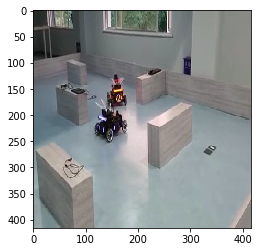

/home/fair/anaconda3/envs/gpxtensor/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


8
OutputImage


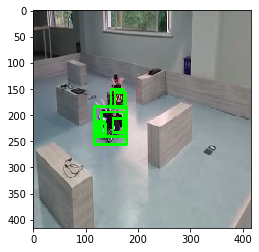

torch.Size([507, 7]) torch.Size([2028, 7]) torch.Size([8112, 7])


In [10]:
import os
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
# 初始化
test_img = 'Dataset/TrainSet/349.jpg'

#指定第2块GPU进行训练
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# 导入模型
nano = YoloNano(class_num=2)
print("Test Start")
if os.path.exists('yolonano.pkl'):
    nano.load_state_dict(torch.load('yolonano.pkl'))
    print("load model sucessfully")
    
nano.cuda()
nano.eval()

img = cv2.imread(test_img)
plt.imshow(img)
print("InputImage")
plt.show()

imginput = torch.Tensor([img]).permute(0,3,1,2)
output1,output2,output3,loss = nano(imginput.cuda())
output1 = output1[0]
output2 = output2[0]
output3 = output3[0]

# output1_ = torch.max(output3,dim=0)[0]
outputshows = []
for i in range(output1.shape[0]):
    if output1[i][4]>0.95:
        outputshows.append(output1[i])
        
for i in range(output2.shape[0]):
    if output2[i][4]>0.95:
        outputshows.append(output2[i]) 

for i in range(output3.shape[0]):
    if output3[i][4]>0.95:
        outputshows.append(output3[i])

print(len(outputshows))
for output1_ in outputshows:
    xmin, ymin, xmax, ymax = xywh2xyxy(output1_[0],output1_[1],output1_[2],output1_[3])
    cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(0,255,0),3)
plt.imshow(img)
print("OutputImage")
plt.show()
print(output1.shape,output2.shape,output3.shape)